Find the time dependence of the following components: m_k computation, coupling integrals, A matrix population (with bessels, aside from coupling integrals), b-vector population, and linear solve.

The big O complexity can be reasoned from the code, but getting the relative order of the corresponding coefficients is helpful when MEEM operates at scales where the cubic does not always dominate.

In [1]:
import numpy as np
import time

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from matplotlib.colors import to_rgba, ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [2]:
# Modify Problem to return times for each of the relevant computations.

class TimedProblem(Problem):
  def __init__(self, h, d, a, heaving, NMK, m0, rho, scale = None):
      self.h = h
      self.d = d
      self.a = a
      self.heaving = heaving
      self.NMK = NMK
      self.m0 = m0
      self.rho = rho
      self.scale = a if scale is None else scale
      self.size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
      self.boundary_count = len(NMK) - 1
      self.time_dict = {"mk" : 0,
                        "coupling" : 0,
                        "bessels" : 0,
                        "a matrix" : 0,
                        "b vector" : 0,
                        "matrix solve": 0,
                        "hydros" : 0}
      start = time.perf_counter()
      self.m_k = self.m_k_array()
      end = time.perf_counter()
      self.time_dict["mk"] = end - start

  def a_matrix(self):
      d, NMK, boundary_count, size = self.d, self.NMK, self.boundary_count, self.size
      # localize eigenfunctions
      R_1n, R_2n, diff_R_1n, diff_R_2n = self.R_1n, self.R_2n, self.diff_R_1n, self.diff_R_2n
      # localize block functions
      p_diagonal_block = self.p_diagonal_block
      p_dense_block, p_dense_block_e = self.p_dense_block, self.p_dense_block_e
      v_diagonal_block, v_diagonal_block_e = self.v_diagonal_block, self.v_diagonal_block_e
      v_dense_block, v_dense_block_e = self.v_dense_block, self.v_dense_block_e

      # compute the coupling integrals and store values
      start = time.perf_counter()
      I_nm_vals = self.I_nm_vals()
      I_mk_vals = self.I_mk_vals()
      end = time.perf_counter()
      self.time_dict["coupling"] = end - start
      self.time_dict["bessels"] = 0 # reset the bessel times, since it accumulates

      rows = [] # collection of rows of blocks in A matrix, to be concatenated later

      start = time.perf_counter()
      # Potential Blocks
      col = 0
      for bd in range(boundary_count):
          N = NMK[bd]
          M = NMK[bd + 1]
          if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
              row_height = N
              left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
              right_block = p_dense_block_e(bd, I_mk_vals)
              if bd == 0: # one cylinder
                  rows.append(np.concatenate((left_block1,right_block), axis = 1))
              else:
                  left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                  left_zeros = np.zeros((row_height, col), dtype=complex)
                  rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
          elif bd == 0:
              left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
              if left_diag:
                  row_height = N
                  left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
                  right_block1 = p_dense_block(False, np.vectorize(R_1n), 0, I_nm_vals)
                  right_block2 = p_dense_block(False, np.vectorize(R_2n), 0, I_nm_vals)
              else:
                  row_height = M
                  left_block = p_dense_block(True, np.vectorize(R_1n), 0, I_nm_vals)
                  right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
                  right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
              right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
              block_lst = [left_block, right_block1, right_block2, right_zeros]
              rows.append(np.concatenate(block_lst, axis = 1))
              col += N
          else: # i-i boundary
              left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
              if left_diag:
                  row_height = N
                  left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                  left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                  right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd, I_nm_vals)
                  right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd, I_nm_vals)
              else:
                  row_height = M
                  left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd, I_nm_vals)
                  left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd, I_nm_vals)
                  right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
                  right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
              left_zeros = np.zeros((row_height, col), dtype=complex)
              right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
              block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
              rows.append(np.concatenate(block_lst, axis = 1))
              col += 2 * N

      # Velocity Blocks
      col = 0
      for bd in range(boundary_count):
          N = NMK[bd]
          M = NMK[bd + 1]
          if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
              row_height = M
              left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd, I_mk_vals)
              right_block = v_diagonal_block_e(bd)
              if bd == 0: # one cylinder
                  rows.append(np.concatenate((left_block1,right_block), axis = 1))
              else:
                  left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd, I_mk_vals)
                  left_zeros = np.zeros((row_height, col), dtype=complex)
                  rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
          elif bd == 0:
              left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
              if left_diag:
                  row_height = N
                  left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                  right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                  right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0, I_nm_vals)
              else:
                  row_height = M
                  left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                  right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                  right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0)
              right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
              block_lst = [left_block, right_block1, right_block2, right_zeros]
              rows.append(np.concatenate(block_lst, axis = 1))
              col += N
          else: # i-i boundary
              left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
              if left_diag:
                  row_height = N
                  left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), bd)
                  left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), bd)
                  right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                  right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
              else:
                  row_height = M
                  left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                  left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                  right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
                  right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
              left_zeros = np.zeros((row_height, col), dtype=complex)
              right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
              block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
              rows.append(np.concatenate(block_lst, axis = 1))
              col += 2 * N
      end = time.perf_counter()
      self.time_dict["a matrix"] = end - start - self.time_dict["bessels"]

      ## Concatenate the rows of blocks into the square A matrix
      return np.concatenate(rows, axis = 0)
  
  def b_vector(self):
      start = time.perf_counter()
      b = np.zeros(self.size, dtype=complex)
      index = 0
      d, boundary_count, NMK = self.d, self.boundary_count, self.NMK

      # potential matching
      for boundary in range(boundary_count):
          if boundary == (boundary_count - 1): # i-e boundary
              for n in range(NMK[-2]):
                  b[index] = self.b_potential_end_entry(n, boundary)
                  index += 1
          else: # i-i boundary
              for n in range(self.NMK[boundary + (d[boundary] <= d[boundary + 1])]): # iterate over eigenfunctions for smaller h-d
                  b[index] = self.b_potential_entry(n, boundary)
                  index += 1

      # velocity matching
      for boundary in range(boundary_count):
          if boundary == (boundary_count - 1): # i-e boundary
              for n in range(NMK[-1]):
                  b[index] = self.b_velocity_end_entry(n, boundary)
                  index += 1
          else: # i-i boundary
              for n in range(NMK[boundary + (d[boundary] > d[boundary + 1])]): # iterate over eigenfunctions for larger h-d
                  b[index] = self.b_velocity_entry(n, boundary)
                  index += 1
      end = time.perf_counter()
      self.time_dict["b vector"] = end - start
      return b

  def get_unknown_coeffs(self, a, b):
      start = time.perf_counter()
      result = np.linalg.solve(a,b)
      end = time.perf_counter()
      self.time_dict["matrix solve"] = end - start
      return result
  
  ## Potential blocks
  # arguments: diagonal block on left (T/F), vectorized radial eigenfunction, boundary number
  def p_diagonal_block(self, left, radfunction, bd):
    h, d, a, NMK = self.h, self.d, self.a, self.NMK
    region = bd if left else (bd + 1)
    sign = 1 if left else (-1)
    start = time.perf_counter()
    diagonal = radfunction(list(range(NMK[region])), a[bd], region)
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    return sign * (h - d[region]) * np.diag(diagonal)
  
  # arguments: dense block on left (T/F), vectorized radial eigenfunction, boundary number
  def p_dense_block(self, left, radfunction, bd, I_nm_vals):
    a, NMK = self.a, self.NMK
    I_nm_array = I_nm_vals[0:NMK[bd],0:NMK[bd+1], bd]
    if left: # determine which is region to work in and which is adjacent
        region, adj = bd, bd + 1
        sign = 1
        I_nm_array = np.transpose(I_nm_array)
    else:
        region, adj = bd + 1, bd
        sign = -1
    start = time.perf_counter()
    radial_vector = radfunction(list(range(NMK[region])), a[bd], region)
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    radial_array = np.outer((np.full((NMK[adj]), 1)), radial_vector)
    return sign * radial_array * I_nm_array

  def p_dense_block_e(self, bd, I_mk_vals):
    a, NMK = self.a, self.NMK
    I_mk_array = I_mk_vals
    start = time.perf_counter()
    radial_vector = (np.vectorize(self.Lambda_k, otypes = [complex]))(list(range(NMK[bd+1])), a[bd])
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    radial_array = np.outer((np.full((NMK[bd]), 1)), radial_vector)
    return (-1) * radial_array * I_mk_array

  ## Velocity blocks
  # arguments: diagonal block on left (T/F), vectorized radial eigenfunction, boundary number
  def v_diagonal_block(self, left, radfunction, bd):
    h, d, a, NMK = self.h, self.d, self.a, self.NMK
    region = bd if left else (bd + 1)
    sign = (-1) if left else (1)
    start = time.perf_counter()
    diagonal = radfunction(list(range(NMK[region])), a[bd], region)
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    return sign * (h - d[region]) * np.diag(diagonal)

  # arguments: dense block on left (T/F), vectorized radial eigenfunction, boundary number
  def v_dense_block(self, left, radfunction, bd, I_nm_vals):
    a, NMK = self.a, self.NMK
    I_nm_array = I_nm_vals[0:NMK[bd],0:NMK[bd+1], bd]
    if left: # determine which is region to work in and which is adjacent
        region, adj = bd, bd + 1
        sign = -1
        I_nm_array = np.transpose(I_nm_array)
    else:
        region, adj = bd + 1, bd
        sign = 1
    start = time.perf_counter()
    radial_vector = radfunction(list(range(NMK[region])), a[bd], region)
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    radial_array = np.outer((np.full((NMK[adj]), 1)), radial_vector)
    return sign * radial_array * I_nm_array

  def v_diagonal_block_e(self, bd):
    h, a, NMK = self.h, self.a, self.NMK
    start = time.perf_counter()
    diagonal = (np.vectorize(self.diff_Lambda_k, otypes = [complex]))(list(range(NMK[bd+1])), a[bd])
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    return h * np.diag(diagonal)

  def v_dense_block_e(self, radfunction, bd, I_mk_vals): # for region adjacent to e-type region
    I_km_array = np.transpose(I_mk_vals)
    a, NMK = self.a, self.NMK
    start = time.perf_counter()
    radial_vector = radfunction(list(range(NMK[bd])), a[bd], bd)
    end = time.perf_counter()
    self.time_dict["bessels"] += end - start
    radial_array = np.outer((np.full((NMK[bd + 1]), 1)), radial_vector)
    return (-1) * radial_array * I_km_array

  def timed_hydros(self, x, convention):
      start = time.perf_counter()
      am, dp = self.hydro_coeffs(x, convention)
      end = time.perf_counter()
      self.time_dict["hydros"] = end - start
      return am, dp

In [3]:
# regions is body regions (total regions - 1)

# Vary regions and nmk, and plot according to expected dependence.
nmks = [10, 20, 30, 40, 50]
regions_lst = [10, 20, 30, 40, 50]

h = 100
m0 = 1
rho = 1023
runs = 10

configurations = []

keys = ["mk", "coupling", "bessels", "a matrix", "b vector", "matrix solve", "hydros"]

for regions in regions_lst:
  d = [float(x) for x in np.linspace(5, 0.5, regions)]
  a = [float(x) for x in np.linspace(0.5, 5, regions)]
  heaving = [1] * regions
  for nmk in nmks:
    NMK = [nmk] * (regions + 1)
    config = {"nmk" : nmk,
              "regions" : regions}
    sum_dict = {key: 0 for key in keys}
    for i in range(runs):
      prob = TimedProblem(h, d, a, heaving, NMK, m0, rho)
      a_matrix = prob.a_matrix()
      b_vector = prob.b_vector()
      x = prob.get_unknown_coeffs(a_matrix, b_vector)
      config["am"], config["dp"] = prob.timed_hydros(x, "capytaine")
      for key in keys:
        sum_dict[key] += prob.time_dict[key]
    for key in keys:
      config[key] = sum_dict[key] / runs
    print(regions, nmk)
    configurations.append(config)

10 10
10 20
10 30
10 40
10 50
20 10
20 20
20 30
20 40
20 50
30 10
30 20
30 30
30 40
30 50
40 10
40 20
40 30
40 40
40 50
50 10
50 20
50 30
50 40
50 50


In [4]:
# m_k computations (~ nmk)
# coupling integrals (~ nmk**2 * regions)
# bessel functions (~ nmk * regions)
# other a-matrix parts (~ (nmk * regions)**2)
# b-vector (~ nmk * regions, but most efficient would depend on # of heaving regions as well)
# matrix solve (~ (nmk * regions)**3)
# hydros

# configurations[0].keys()

In [5]:
def plot_dependence(configs, key, relater, xlab):
  xs = []
  ys = []
  for config in configs:
    xs.append(relater(config["nmk"], config["regions"]))
    ys.append(config[key])
  plt.scatter(xs, ys, color = "blue")
  coeffs = np.polyfit(xs, ys, deg=1)
  fit_fn = np.poly1d(coeffs)
  x_line = np.linspace(min(xs), max(xs), 100)
  slope, intercept = coeffs
  equation = f"y = {slope:.2e}x + {intercept:.2e}"
  plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
          fontsize=12, verticalalignment='top', color='red')
  plt.plot(x_line, fit_fn(x_line), color="red", label="Best-fit line")
  plt.xlabel(xlab)
  plt.ylabel("Time")
  plt.legend()
  plt.title(key + " computation")
  plt.show()

def plot_dependence2(configs, key, relater, xlab):
  xs = []
  ys = []
  for config in configs:
    xs.append(relater(config["nmk"], config["regions"]))
    ys.append(config[key])
  plt.scatter(xs, ys, color = "blue")
  coeffs = np.polyfit(xs, ys, deg=2)
  fit_fn = np.poly1d(coeffs)
  x_line = np.linspace(min(xs), max(xs), 100)
  a, b, c = coeffs
  equation = f"y = {a:.2e}x² + {b:.2e}x + {c:.2e}"
  plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
           fontsize=12, verticalalignment='top', color='green')
  plt.plot(x_line, fit_fn(x_line), color="red", label="Best-fit line")
  plt.xlabel(xlab)
  plt.ylabel("Time")
  plt.legend()
  plt.title(key + " computation")
  plt.show()

In [16]:
keys = ["mk", "coupling", "bessels", "a matrix", "b vector", "matrix solve", "hydros"]

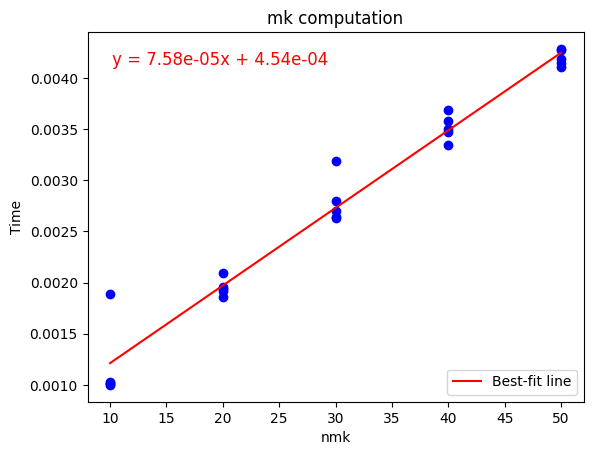

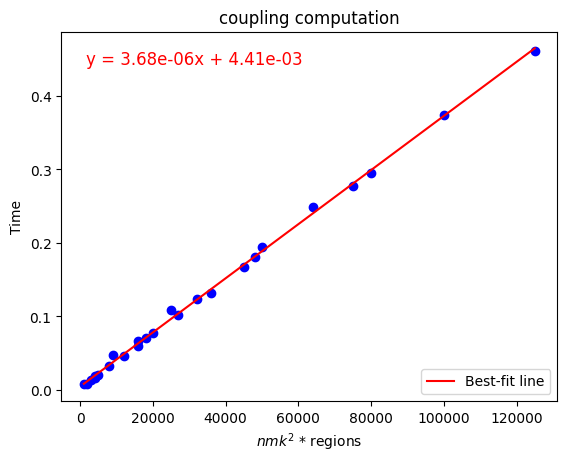

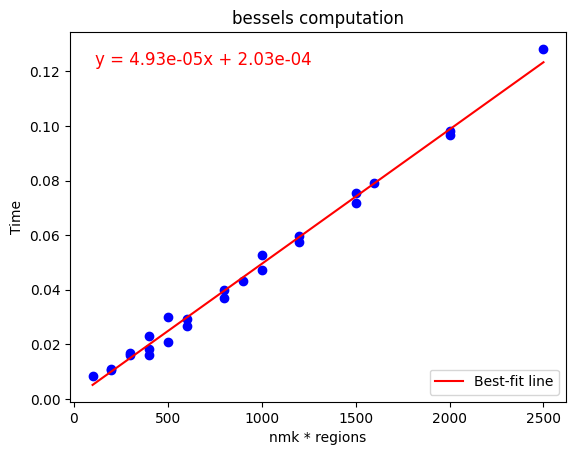

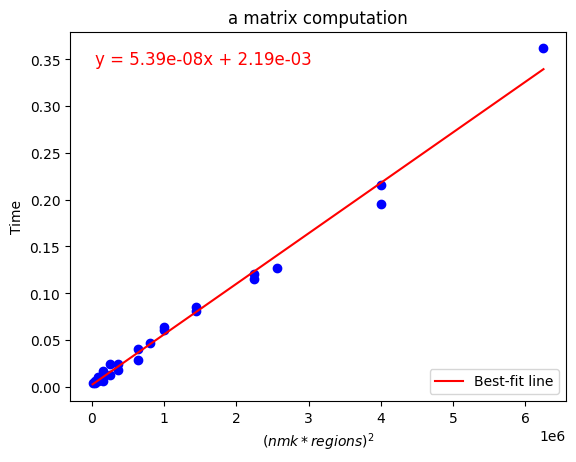

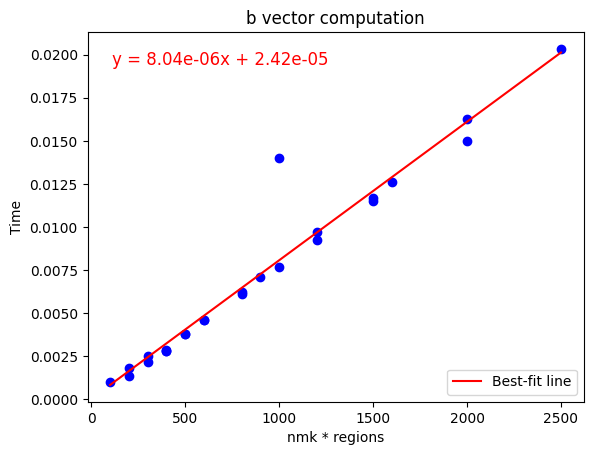

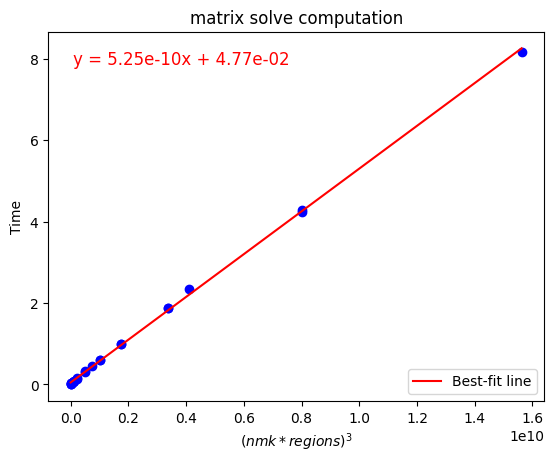

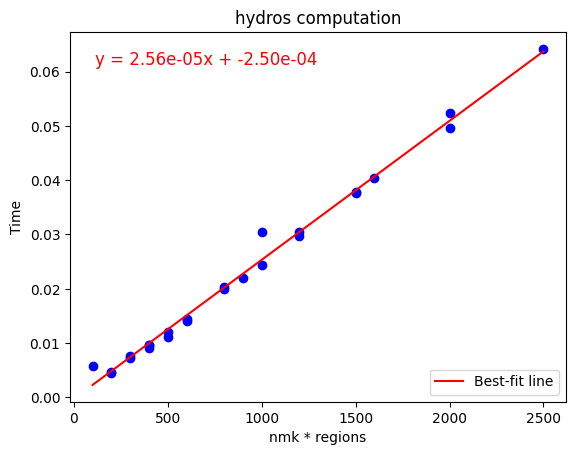

In [70]:
def rel_mk(nmk, regions):
  return nmk
plot_dependence(configurations, "mk", rel_mk, "nmk")

def rel_coupling(nmk, regions):
  return nmk**2 * regions
plot_dependence(configurations, "coupling", rel_coupling, "$nmk^2$ * regions")

def rel_bessel(nmk, regions):
  return (nmk * regions)
plot_dependence(configurations, "bessels", rel_bessel, "nmk * regions")

def rel_a_matrix(nmk, regions):
  return (nmk * regions) ** 2
plot_dependence(configurations, "a matrix", rel_a_matrix, "$(nmk * regions)^2$")

def rel_bv(nmk, regions):
  return nmk * regions
plot_dependence(configurations, "b vector", rel_bv, "nmk * regions")

def rel_ms(nmk, regions):
  return (nmk * regions)**3
plot_dependence(configurations, "matrix solve", rel_ms, "$(nmk * regions)^3$")

def rel_hd(nmk, regions):
  return (nmk * regions)
plot_dependence(configurations, "hydros", rel_hd, "nmk * regions")

In [13]:
def meem_computation_time(NMK):
  unknown_coeffs = NMK[0] + 2 * sum(NMK[1:-1]) + NMK[-1]
  t1 = 7.6e-5 * NMK[-1]
  t2 = 3.7e-6 * sum([NMK[i] * NMK[i+1] for i in range(len(NMK) - 1)])
  t3 = 4.9e-5 * unknown_coeffs
  t4 = 5.4e-8 * (unknown_coeffs)**2
  t5 = 8.0e-6 * unknown_coeffs
  t6 = 5.3e-10 * (unknown_coeffs)**3
  t7 = 2.6e-5 * unknown_coeffs
  return sum([t1, t2, t3, t4, t5, t6, t7])

In [2]:
def times(nmk, regions, factor = 1):
  return {"mk" : 7.6e-5 * nmk * factor,
          "coupling" : 3.7e-6 * (nmk**2) * regions * (factor ** 3),
          "bessels" : 4.9e-5 * nmk * regions * (factor ** 2),
          "a matrix" : 5.4e-8 * (nmk * regions)**2 * (factor ** 4),
          "b vector" : 8.0e-6 * (nmk * regions) * (factor ** 2),
          "matrix solve" : 5.3e-10 * (nmk * regions) ** 3 * (factor ** 6),
          "hydros" : 2.6e-5 * (nmk * regions) * (factor**2)}

def get_times(nmks, regions_lst):
  keys = ["mk", "coupling", "bessels", "a matrix", "b vector", "matrix solve", "hydros"]
  runtime_surfaces = {key: np.zeros((len(regions_lst), len(nmks))) for key in keys}
  for j, regions in enumerate(regions_lst):
    for i, nmk in enumerate(nmks):
      result = times(nmk, regions)
      for key in keys:
        runtime_surfaces[key][j, i] = result[key]
  return runtime_surfaces

def plot_3D(nmks, regions_lst):
  X, Y = np.meshgrid(nmks, regions_lst)
  runtime_surfaces = get_times(nmks, regions_lst)
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  cmap = plt.get_cmap("tab10")
  colors = [to_rgba(cmap(i), alpha=0.6) for i in range(len(runtime_surfaces))]

  for (name, Z), color in zip(runtime_surfaces.items(), colors):
      ax.plot_surface(X, Y, Z, alpha=0.6, label=name, color=color)
      ax.plot([], [], label=name, color=color)  # legend workaround

  ax.set_xlabel("nmk/region")
  ax.set_ylabel("regions")
  ax.set_zlabel("Runtime")
  ax.set_title("Function Runtimes over nmk/region and regions")
  ax.legend()
  plt.tight_layout()
  plt.show()

def plot_times_contour(nmks, regions_lst, keys, key_colors, exclude = []):
  X, Y = np.meshgrid(nmks, regions_lst)
  keys = keys.copy()
  for key in exclude:
      keys.remove(key)

  func_to_int = {key: i for i, key in enumerate(keys)}

  labels = np.zeros((len(regions_lst), len(nmks)), dtype = int)

  for j, regions in enumerate(regions_lst):
    for i, nmk in enumerate(nmks):
        result = times(nmk, regions)
        for key in exclude:
          del result[key]
        # get the function with the maximum (slowest) runtime
        slowest_func = max(result, key=result.get)
        labels[j, i] = func_to_int[slowest_func]

  plt.figure(figsize=(6, 6), constrained_layout=True)
  colors_in_order = [key_colors[key] for key in keys]
  cmap = ListedColormap(colors_in_order)
  norm = BoundaryNorm(np.arange(-0.5, len(colors_in_order)+0.5), len(colors_in_order))
  im = plt.imshow(labels, cmap=cmap, norm = norm, origin='lower', extent=[
    nmks[0] - 0.5, nmks[-1] + 0.5, regions_lst[0] - 0.5, regions_lst[-1] + 0.5], interpolation='none')
  plt.xlabel("terms per region")
  plt.ylabel("region count")
  plt.title("Dominating function at each (terms/region, regions)")

  # Manual legend using patches
  legend_handles = [Patch(color = key_colors[key], label=key) for key in keys]
  # plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

  # plt.tight_layout()
  plt.show()

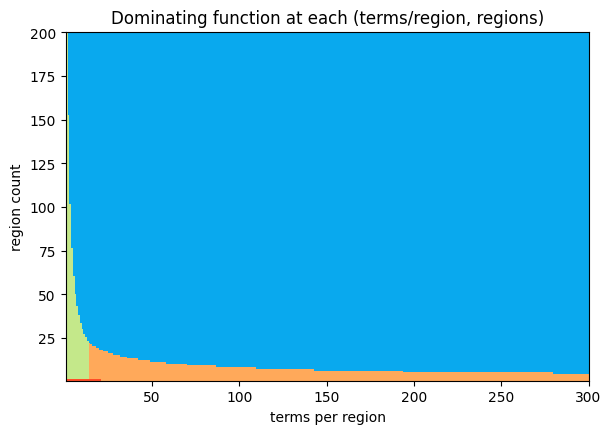

In [68]:
cmap = cm.get_cmap("rainbow") #gnuplot
key_colors = {key: cmap(1 - (0.1 + 0.8 * i / (len(keys) - 1))) for i, key in enumerate(keys)}
nmks = list(range(1, 301))
regions_lst = list(range(1, 201))
plot_times_contour(nmks, regions_lst, keys, key_colors)
# plot_times_contour(nmks, regions_lst, keys, key_colors, exclude = ["mk"])
# plot_times_contour(nmks, regions_lst, keys, key_colors, exclude = ["matrix solve"])
# plot_times_contour(nmks, regions_lst, keys, key_colors, exclude = ["matrix solve", "mk", "coupling"])

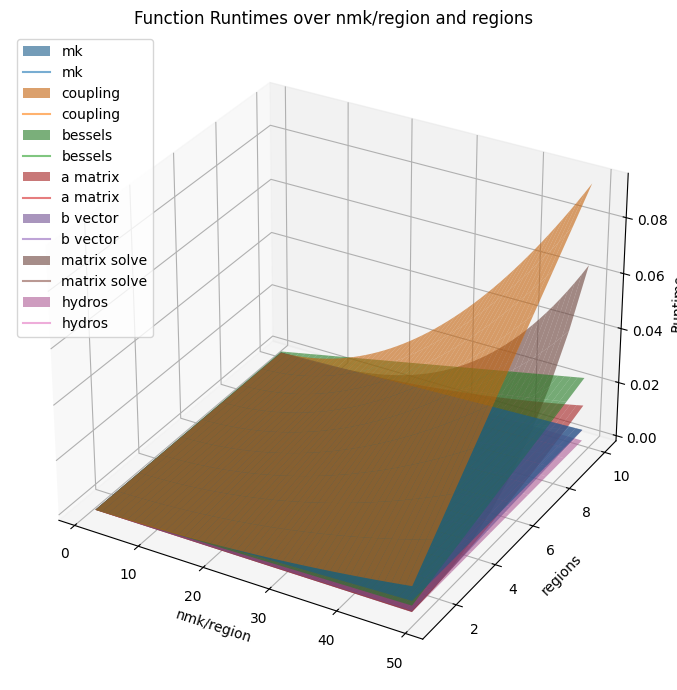

In [12]:
plot_3D(list(range(1, 50)), list(range(1, 11)))

In [24]:
# RM3 bar chart
# Vary regions and nmk, and plot according to expected dependence.
base_nmk = [63, 84, 42]
meem_mults = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

h = 100
m0 = 0.1
rho = 1023
runs = 10
heaving = [0, 1]

rm3_configs = []

keys = ["mk", "coupling", "bessels", "a matrix", "b vector", "matrix solve", "hydros"]

for mult in meem_mults:
  NMK = [int(np.ceil(entry * mult)) for entry in base_nmk]
  config = {"NMK" : NMK}
  sum_dict = {key: 0 for key in keys}
  for i in range(runs):
    prob = TimedProblem(h, d, a, heaving, NMK, m0, rho)
    a_matrix = prob.a_matrix()
    b_vector = prob.b_vector()
    x = prob.get_unknown_coeffs(a_matrix, b_vector)
    config["am"], config["dp"] = prob.timed_hydros(x, "capytaine")
    for key in keys:
      sum_dict[key] += prob.time_dict[key]
  for key in keys:
    config[key] = sum_dict[key] / runs
  print(NMK)
  rm3_configs.append(config)

[13, 17, 9]
[26, 34, 17]
[38, 51, 26]
[51, 68, 34]
[63, 84, 42]
[76, 101, 51]
[89, 118, 59]
[101, 135, 68]
[114, 152, 76]
[126, 168, 84]


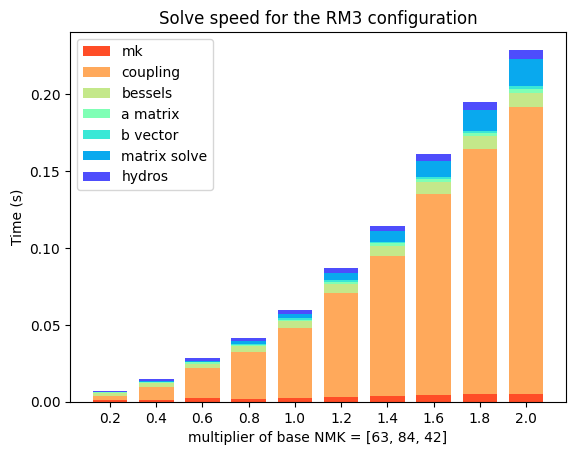

In [30]:
def bar_chart(data, keys, key_colors):
  x = meem_mults
  bottom = np.zeros(len(data))
  for k in keys:
    heights = np.array([record.get(k, 0) for record in data])
    plt.bar(x, heights, bottom=bottom, width= 0.15, color=key_colors[k], label=k)
    bottom += heights

  plt.xticks(x)
  plt.xlabel("multiplier of base NMK = [63, 84, 42]")
  plt.ylabel("Time (s)")
  plt.title("Solve speed for the RM3 configuration")
  plt.legend()
  plt.show()

bar_chart(rm3_configs, keys, key_colors)